In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

In [14]:
val_idxs = list(range(800))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [15]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [16]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [17]:
x,y = next(iter(md.trn_dl))

In [18]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

## Simple upsample

In [19]:
f = resnext50
cut,lr_cut = model_meta[f]

In [20]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [21]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

## U-net (ish)

In [22]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [23]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [24]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [25]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [26]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [27]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [28]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 8, 8]),
            

In [29]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 16, 16]),
 torch.Size([3, 256, 8, 8]),
 torch.Size([3, 512, 4, 4]),
 torch.Size([3, 1024, 2, 2])]

In [30]:
learn.freeze_to(1)

 92%|█████████▏| 46/50 [00:44<00:03,  1.03it/s, loss=1.91] 

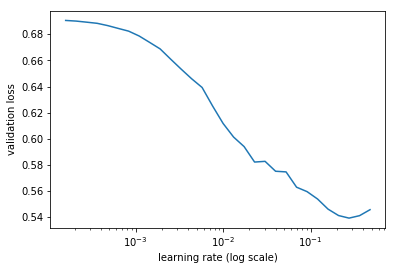

In [31]:
learn.lr_find()
learn.sched.plot()

In [32]:
lr=1e-1
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [33]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.324247   0.472103   0.852705   0.694817  
    1      0.283622   0.253699   0.905012   0.806624       
    2      0.249458   0.255802   0.906226   0.810872       
    3      0.226629   0.213419   0.914518   0.824374       
    4      0.209345   0.225227   0.912286   0.820093       
    5      0.19387    0.210468   0.917145   0.830633       
    6      0.181727   0.209462   0.921163   0.840085       
    7      0.169106   0.194356   0.920583   0.84029        


[array([0.19436]), 0.92058349609375, 0.8402895265508268]

In [34]:
learn.save('32urn-tmp')

In [35]:
learn.load('32urn-tmp')

In [36]:
learn.unfreeze()
learn.bn_freeze(True)

In [37]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.143642   0.210144   0.921207   0.839009  
    1      0.16941    0.282228   0.900845   0.79157        
    2      0.188675   0.19158    0.924955   0.848567       
    3      0.17764    0.226824   0.926375   0.836696       
    4      0.164056   0.20259    0.914991   0.831125       
    5      0.148839   0.204995   0.92495    0.847191       
    6      0.127341   0.241399   0.920962   0.839829       
    7      0.120672   0.217201   0.927106   0.855566       
    8      0.108646   0.200481   0.931129   0.861451       
    9      0.102039   0.193397   0.931185   0.861026       
    10     0.095178   0.200855   0.930656   0.863405        
    11     0.095023   0.199568   0.933068   0.866556        
    12     0.089719   0.230297   0.931492   0.861879        
    13     0.084264   0.206434   0.933096   0.866298        
    14     0.081345   0.19666    0.930144   0.862112        
    15     0.077077   0.219968   0.93403

[array([0.22312]), 0.935166015625, 0.869520587574261]

In [38]:
learn.save('32urn-0')

In [39]:
learn.load('32urn-0')

In [40]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

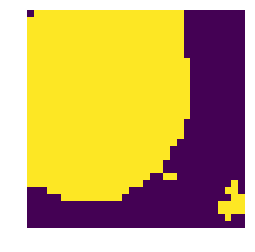

In [41]:
show_img(py[0]>0);

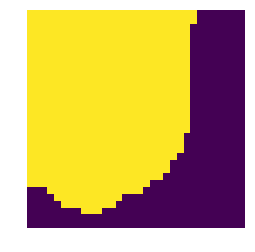

In [42]:
show_img(y[0]);

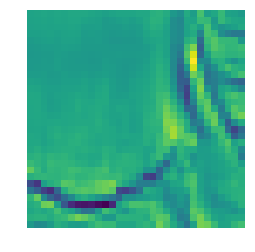

In [43]:
show_img(x[0][0]);

In [44]:
m.close()

## 64x64

In [45]:
sz=64
bs=64

In [46]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [47]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [48]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [49]:
learn.freeze_to(1)

In [50]:
learn.load('32urn-0')

In [51]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.20787    0.196369   0.921163   0.849782  
    1      0.190315   0.195535   0.929301   0.857031       
    2      0.167553   0.167918   0.94       0.877927       
    3      0.149698   0.171547   0.933737   0.867414       
    4      0.136761   0.146862   0.943618   0.890794       


[array([0.14686]), 0.9436184692382813, 0.8907937305793991]

In [52]:
learn.save('64urn-tmp')

In [53]:
learn.unfreeze()
learn.bn_freeze(True)

In [54]:
learn.load('64urn-tmp')

In [55]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.118543   0.188184   0.935487   0.866969  
    1      0.153624   0.217721   0.925561   0.848182       
    2      0.127775   0.161554   0.945798   0.890118       
    3      0.124384   0.144249   0.948368   0.897312       
    4      0.108919   0.151827   0.948874   0.897692       
    5      0.093426   0.166632   0.945685   0.891164        
    6      0.087289   0.152851   0.949087   0.896695        
    7      0.0775     0.161239   0.949252   0.897658        


[array([0.16124]), 0.9492520141601563, 0.897657514571328]

In [56]:
learn.save('64urn')

In [57]:
learn.load('64urn')

In [58]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

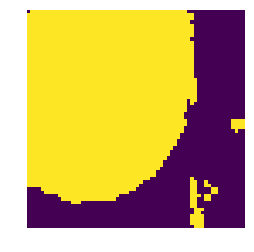

In [59]:
show_img(py[0]>0);

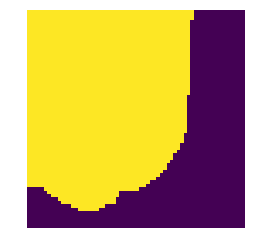

In [60]:
show_img(y[0]);

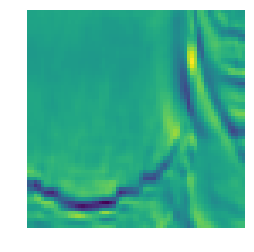

In [61]:
show_img(x[0][0]);

In [62]:
m.close()

## 128x128

In [63]:
sz=128
bs=64

In [64]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [65]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [66]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [67]:
learn.load('64urn')

In [68]:
learn.freeze_to(1)

In [69]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.190902   0.240317   0.925656   0.85219   
    1      0.169987   0.140026   0.941675   0.887554       


[array([0.14003]), 0.9416754150390625, 0.8875535400489756]

In [70]:
learn.save('128urn-tmp')

In [71]:
learn.load('128urn-tmp')

In [72]:
learn.unfreeze()
learn.bn_freeze(True)

In [73]:
lrs = np.array([lr/200,lr/30,lr])

In [74]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.123318   0.155568   0.947259   0.888253  
    1      0.112886   0.143894   0.947781   0.897421       
    2      0.100704   0.144715   0.949773   0.900395       
    3      0.091697   0.148766   0.949425   0.899728        


[array([0.14877]), 0.949425048828125, 0.8997282208582614]

In [75]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.092494   0.16189    0.943652   0.890883  
    1      0.085716   0.157379   0.948921   0.897734        
    2      0.077319   0.157753   0.950497   0.8994          
    3      0.070111   0.16135    0.948823   0.897123        


[array([0.16135]), 0.9488227081298828, 0.8971230537381666]

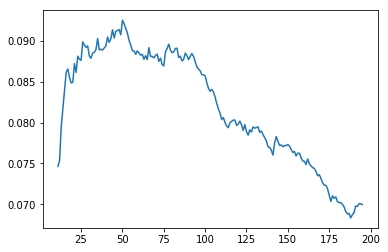

In [76]:
learn.sched.plot_loss()

In [77]:
learn.save('128urn')

In [78]:
learn.load('128urn')

In [79]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

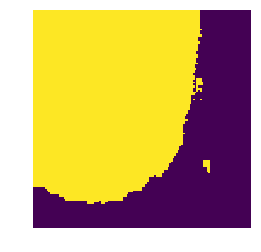

In [80]:
show_img(py[0]>0);

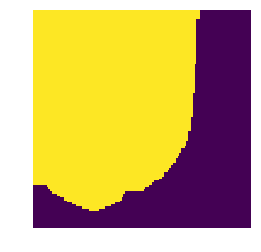

In [81]:
show_img(y[0]);

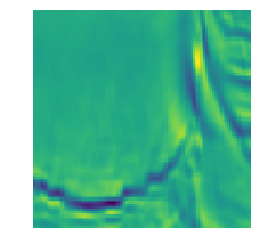

In [82]:
show_img(x[0][0]);

In [83]:
y.shape

torch.Size([64, 128, 128])

# Test on original validation without TTA

In [143]:
val_x

array(['/home/giles/Downloads/fastai_data/salt/train-128/d2b40a2781.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/89dba191b1.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/e6ac2a35cd.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/236a5cc090.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/f30e47cb36.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/e0bde1cf11.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/ad16edc8be.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/fa92bed2b1.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/6d46f994ac.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/eabed5b2b4.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/1cad8c327b.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/2fe4adfd48.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/24d67576d0.png',
       '/home/giles/Downloads/fastai_d

In [144]:
x_names_orig = np.array(glob(f'{PATH}/train/*'))
y_names_orig = np.array(glob(f'{PATH}/train_masks/*'))

In [145]:
val_idxs_orig = list(range(800))
((val_x_orig,trn_x_orig),(val_y_orig,trn_y_orig)) = split_by_idx(val_idxs_orig, x_names_orig, y_names_orig)

In [146]:
val_x_orig

array(['/home/giles/Downloads/fastai_data/salt/train/d2b40a2781.png',
       '/home/giles/Downloads/fastai_data/salt/train/89dba191b1.png',
       '/home/giles/Downloads/fastai_data/salt/train/e6ac2a35cd.png',
       '/home/giles/Downloads/fastai_data/salt/train/236a5cc090.png',
       '/home/giles/Downloads/fastai_data/salt/train/f30e47cb36.png',
       '/home/giles/Downloads/fastai_data/salt/train/e0bde1cf11.png',
       '/home/giles/Downloads/fastai_data/salt/train/ad16edc8be.png',
       '/home/giles/Downloads/fastai_data/salt/train/fa92bed2b1.png',
       '/home/giles/Downloads/fastai_data/salt/train/6d46f994ac.png',
       '/home/giles/Downloads/fastai_data/salt/train/eabed5b2b4.png',
       '/home/giles/Downloads/fastai_data/salt/train/1cad8c327b.png',
       '/home/giles/Downloads/fastai_data/salt/train/2fe4adfd48.png',
       '/home/giles/Downloads/fastai_data/salt/train/24d67576d0.png',
       '/home/giles/Downloads/fastai_data/salt/train/60b3d0d613.png',
       '/home/giles/

In [147]:
sz=128
bs=64

In [148]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x_orig,trn_y_orig), (val_x_orig,val_y_orig), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [149]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [150]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [151]:
learn.load('128urn')

In [238]:
log_preds = learn.predict_dl(md.val_dl)

In [189]:
probs = np.exp(log_preds)

In [207]:
probs.shape

(800, 128, 128)

In [237]:
y.shape

(800, 128, 128)

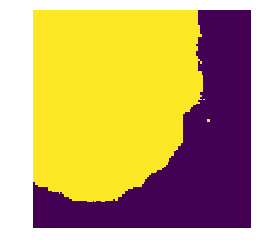

In [240]:
show_img(log_preds[0]>0.5);

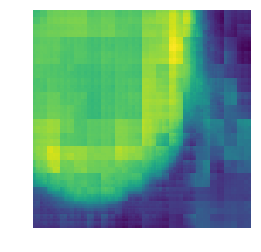

In [239]:
show_img(log_preds[0]);

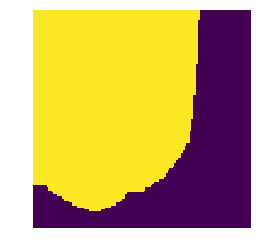

In [236]:
show_img(y[0]);

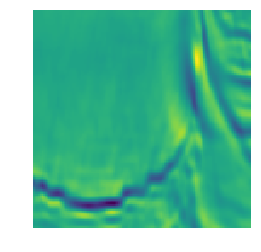

In [198]:
show_img(x[0][0]);

# Optimise threshold

In [241]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [242]:
thres = np.linspace(-5, 5, 50)
thres_ioc = [iou_metric_batch(y, np.int32(log_preds > t)) for t in tqdm_notebook(thres)]

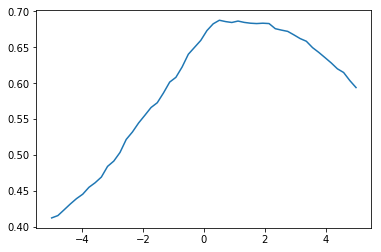

In [243]:
plt.plot(thres, thres_ioc);

In [244]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.5102040816326534, 0.687625)

In [248]:
thres = np.linspace(0, 1, 200)
thres_ioc = [iou_metric_batch(y, np.int32(log_preds > t)) for t in tqdm_notebook(thres)]

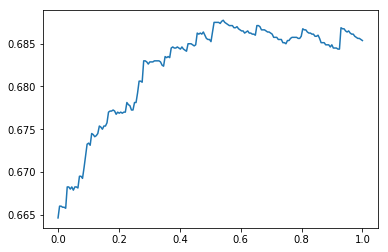

In [249]:
plt.plot(thres, thres_ioc);

In [250]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.542713567839196, 0.6877500000000001)

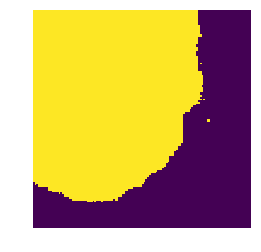

In [107]:
show_img(probs[0]>best_thres);

# Run on test

In [251]:
(PATH/'test-128').mkdir(exist_ok=True)

In [252]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [253]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [254]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [255]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [256]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [257]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [258]:
learn.load('128urn')

In [259]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

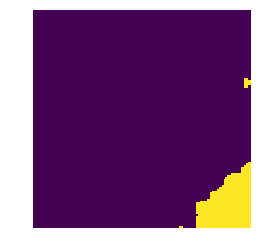

In [260]:
show_img(py[6]>best_thres);

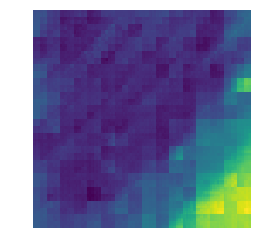

In [261]:
show_img(py[6]);

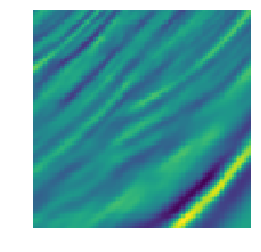

In [262]:
show_img(y[6]);

In [263]:
probs = learn.predict_dl(md.test_dl)

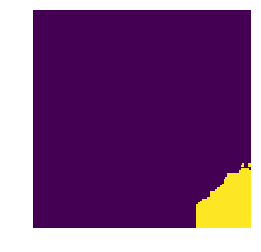

In [264]:
show_img(probs[6]>best_thres);

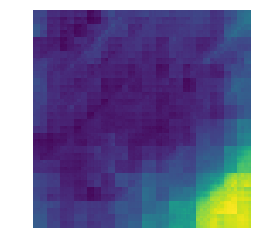

In [265]:
show_img(probs[6]);

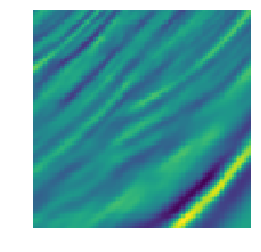

In [266]:
show_img(y[6]);

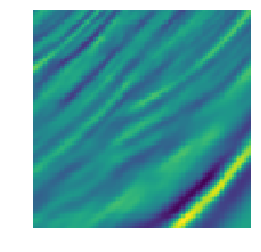

In [267]:
show_img(x[6][0]);

In [268]:
with open(f'{PATH}/probs.pkl', 'wb') as fout: #Save results
    pickle.dump(probs, fout)

In [269]:
probs.shape

(18000, 128, 128)

In [270]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [271]:
resizePreds.shape

(18000, 101, 101)

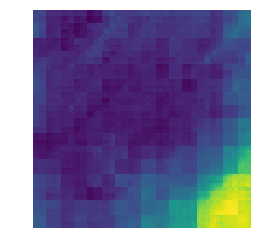

In [272]:
show_img(resizePreds[6]);

In [273]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [274]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [275]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [276]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [277]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [278]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [279]:
sub

,rle_mask
id,
ac26efe98e,1 38 102 38 203 38 304 38 405 38 506 38 607 38...
0a5eac8775,
bdb1c1fcbf,
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,7767 11 7866 13 7967 13 8068 13 8168 14 8269 1...
696d91b37e,
73053e4d03,1 6 102 9 203 9 304 11 405 12 506 13 607 13 70...


# Test on original validation

In [84]:
val_x

array(['/home/giles/Downloads/fastai_data/salt/train-128/d2b40a2781.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/89dba191b1.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/e6ac2a35cd.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/236a5cc090.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/f30e47cb36.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/e0bde1cf11.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/ad16edc8be.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/fa92bed2b1.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/6d46f994ac.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/eabed5b2b4.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/1cad8c327b.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/2fe4adfd48.png',
       '/home/giles/Downloads/fastai_data/salt/train-128/24d67576d0.png',
       '/home/giles/Downloads/fastai_d

In [85]:
x_names_orig = np.array(glob(f'{PATH}/train/*'))
y_names_orig = np.array(glob(f'{PATH}/train_masks/*'))

In [86]:
val_idxs_orig = list(range(800))
((val_x_orig,trn_x_orig),(val_y_orig,trn_y_orig)) = split_by_idx(val_idxs_orig, x_names_orig, y_names_orig)

In [87]:
val_x_orig

array(['/home/giles/Downloads/fastai_data/salt/train/d2b40a2781.png',
       '/home/giles/Downloads/fastai_data/salt/train/89dba191b1.png',
       '/home/giles/Downloads/fastai_data/salt/train/e6ac2a35cd.png',
       '/home/giles/Downloads/fastai_data/salt/train/236a5cc090.png',
       '/home/giles/Downloads/fastai_data/salt/train/f30e47cb36.png',
       '/home/giles/Downloads/fastai_data/salt/train/e0bde1cf11.png',
       '/home/giles/Downloads/fastai_data/salt/train/ad16edc8be.png',
       '/home/giles/Downloads/fastai_data/salt/train/fa92bed2b1.png',
       '/home/giles/Downloads/fastai_data/salt/train/6d46f994ac.png',
       '/home/giles/Downloads/fastai_data/salt/train/eabed5b2b4.png',
       '/home/giles/Downloads/fastai_data/salt/train/1cad8c327b.png',
       '/home/giles/Downloads/fastai_data/salt/train/2fe4adfd48.png',
       '/home/giles/Downloads/fastai_data/salt/train/24d67576d0.png',
       '/home/giles/Downloads/fastai_data/salt/train/60b3d0d613.png',
       '/home/giles/

In [88]:
sz=128
bs=64

In [89]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x_orig,trn_y_orig), (val_x_orig,val_y_orig), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [90]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [91]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [92]:
learn.load('128urn')

In [235]:
log_preds, y = learn.TTA()

In [94]:
probs = np.mean(log_preds,0)

In [95]:
log_preds.shape

(5, 800, 128, 128)

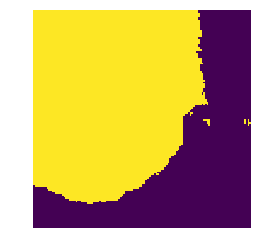

In [96]:
show_img(probs[0]>0);

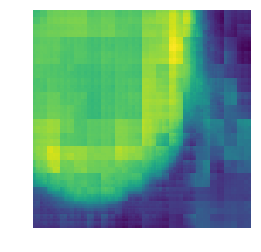

In [97]:
show_img(probs[0]);

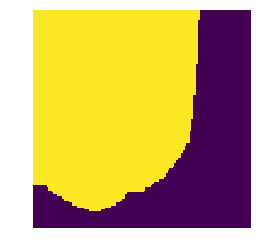

In [98]:
show_img(y[0]);

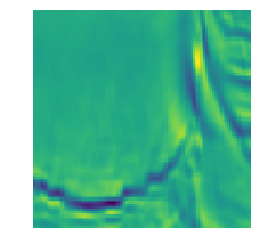

In [99]:
show_img(x[0][0]);

# Optimise threshold

In [100]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [101]:
thres = np.linspace(-5, 5, 200)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

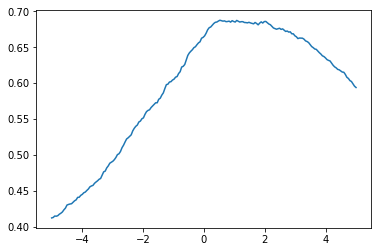

In [102]:
plt.plot(thres, thres_ioc);

In [103]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.5276381909547743, 0.6875)

In [104]:
thres = np.linspace(0, 1, 200)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

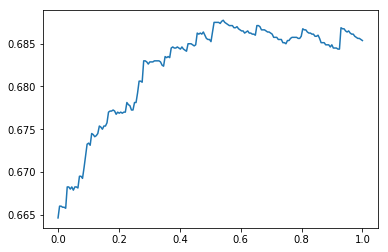

In [105]:
plt.plot(thres, thres_ioc);

In [106]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.542713567839196, 0.6877500000000001)

In [140]:
thres = np.linspace(1, 3, 200)
thres_ioc = [iou_metric_batch(y, np.int32(probs > t)) for t in tqdm_notebook(thres)]

KeyboardInterrupt: 

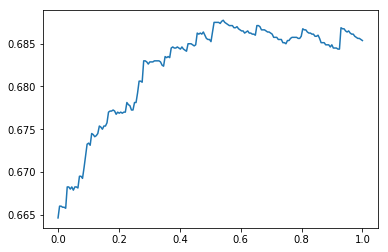

In [105]:
plt.plot(thres, thres_ioc);

In [106]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.542713567839196, 0.6877500000000001)

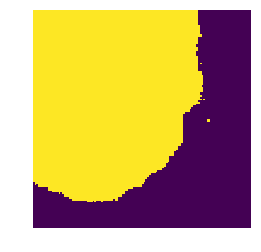

In [107]:
show_img(probs[0]>best_thres);

# Run on test

In [108]:
(PATH/'test-128').mkdir(exist_ok=True)

In [109]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [110]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [111]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [112]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [113]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [114]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [115]:
learn.load('128urn')

In [116]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

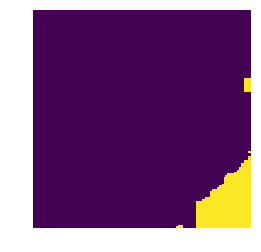

In [117]:
show_img(py[6]>0);

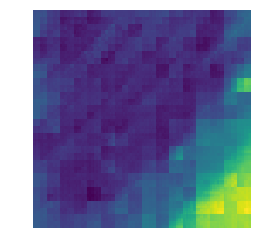

In [118]:
show_img(py[6]);

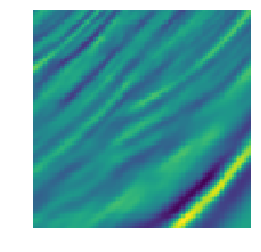

In [119]:
show_img(y[6]);

In [120]:
log_preds, y = learn.TTA(is_test=True)

In [121]:
probs = np.mean(log_preds,0)

In [122]:
log_preds.shape

(5, 18000, 128, 128)

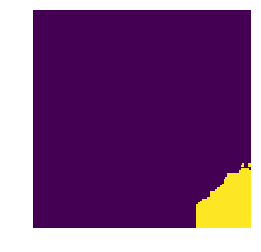

In [141]:
show_img(probs[6]>best_thres);

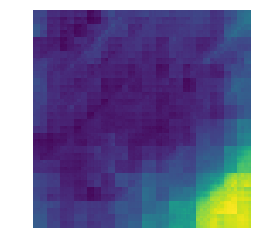

In [124]:
show_img(probs[6]);

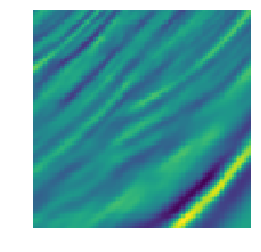

In [125]:
show_img(y[6]);

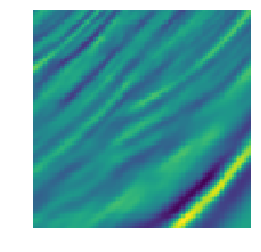

In [126]:
show_img(x[6][0]);

In [127]:
with open(f'{PATH}/probs.pkl', 'wb') as fout: #Save results
    pickle.dump(probs, fout)

In [128]:
probs.shape

(18000, 128, 128)

In [129]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [130]:
resizePreds.shape

(18000, 101, 101)

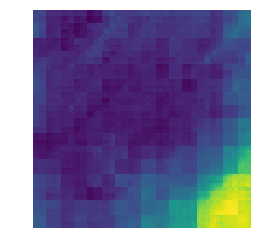

In [131]:
show_img(resizePreds[6]);

In [132]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [133]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [134]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [135]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [136]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [142]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [138]:
sub

,rle_mask
id,
ac26efe98e,1 38 102 38 203 38 304 38 405 38 506 38 607 38...
0a5eac8775,
bdb1c1fcbf,
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,7767 11 7866 13 7967 13 8068 13 8168 14 8269 1...
696d91b37e,
73053e4d03,1 6 102 9 203 9 304 11 405 12 506 13 607 13 70...
